# **Autogluon Experiment including original data**

In [ ]:
%%capture
%pip install setuptools wheel autogluon.tabular[all,skex] dask[dataframe]
%pip install -U -q ipywidgets
%pip install -U scikit-learn

In [1]:
# Import basic libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
from autogluon.core.metrics import make_scorer
import sklearn
warnings.filterwarnings('ignore')

# Import specific libraries
from autogluon.tabular import TabularDataset, TabularPredictor

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
base_path = os.getenv('DATA_FOLDER_PATH', 'Data/')
#base_path = os.getenv('DATA_FOLDER_PATH', '/content/drive/MyDrive/DS_Projects/Playground_Series/Ps4e12_Regression_Insuranse_Premium_Prediction/Data/')

train = pd.read_csv(os.path.join(base_path, 'train.csv'))
test = pd.read_csv(os.path.join(base_path, 'test.csv'))
submission = pd.read_csv(os.path.join(base_path, 'sample_submission.csv'))
original = pd.read_csv(os.path.join(base_path, 'Insurance Premium Prediction Dataset.csv'))

In [3]:
train.set_index('id', inplace=True)
test.set_index('id', inplace=True)

# Renaming columns for consistency
train.columns = train.columns.str.lower()
test.columns = test.columns.str.lower()
original.columns = original.columns.str.lower()
train.columns = [col.replace(" ", "_") for col in train.columns]
test.columns = [col.replace(" ", "_") for col in test.columns]
original.columns = [col.replace(" ", "_") for col in original.columns]
original  = original[train.columns]
original = original[original['premium_amount'] > 0]

train

,age,gender,annual_income,marital_status,number_of_dependents,education_level,occupation,health_score,location,policy_type,previous_claims,vehicle_age,credit_score,insurance_duration,policy_start_date,customer_feedback,smoking_status,exercise_frequency,property_type,premium_amount
id,,,,,,,,,,,,,,,,,,,,
0,19.0,Female,10049.0,Married,1.0,Bachelor's,Self-Employed,22.598761,Urban,Premium,2.0,17.0,372.0,5.0,2023-12-23 15:21:39.134960,Poor,No,Weekly,House,2869.0
1,39.0,Female,31678.0,Divorced,3.0,Master's,NaN,15.569731,Rural,Comprehensive,1.0,12.0,694.0,2.0,2023-06-12 15:21:39.111551,Average,Yes,Monthly,House,1483.0
2,23.0,Male,25602.0,Divorced,3.0,High School,Self-Employed,47.177549,Suburban,Premium,1.0,14.0,NaN,3.0,2023-09-30 15:21:39.221386,Good,Yes,Weekly,House,567.0
3,21.0,Male,141855.0,Married,2.0,Bachelor's,NaN,10.938144,Rural,Basic,1.0,0.0,367.0,1.0,2024-06-12 15:21:39.226954,Poor,Yes,Daily,Apartment,765.0
4,21.0,Male,39651.0,Single,1.0,Bachelor's,Self-Employed,20.376094,Rural,Premium,0.0,8.0,598.0,4.0,2021-12-01 15:21:39.252145,Poor,Yes,Weekly,House,2022.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1199995,36.0,Female,27316.0,Married,0.0,Master's,Unemployed,13.772907,Urban,Premium,NaN,5.0,372.0,3.0,2023-05-03 15:21:39.257696,Poor,No,Daily,Apartment,1303.0
1199996,54.0,Male,35786.0,Divorced,NaN,Master's,Self-Employed,11.483482,Rural,Comprehensive,NaN,10.0,597.0,4.0,2022-09-10 15:21:39.134960,Poor,No,Weekly,Apartment,821.0
1199997,19.0,Male,51884.0,Divorced,0.0,Master's,NaN,14.724469,Suburban,Basic,0.0,19.0,NaN,6.0,2021-05-25 15:21:39.106582,Good,No,Monthly,Condo,371.0


<Axes: >

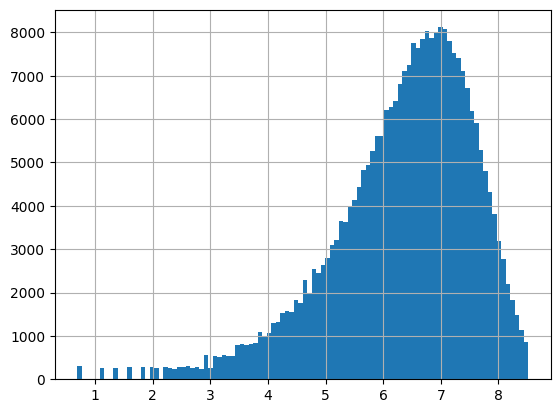

In [4]:
# Lets look at the original data target distribution
original['premium_amount_log'] = np.log1p(original['premium_amount'])
original['premium_amount_log'].hist(bins=100)


<Axes: >

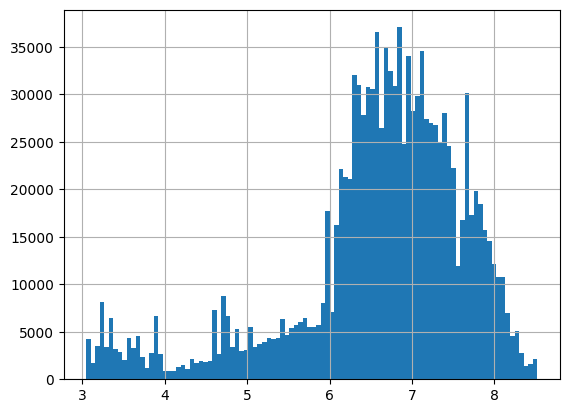

In [5]:
train['premium_amount_log'] = np.log1p(train['premium_amount'])
train['premium_amount_log'].hist(bins=100)


# **Fusing original data**

In [6]:
train_fused = pd.concat([train, original, original, original])
train_fused = train_fused.sample(n=1_000_000, random_state=42)
train_fused = train_fused.reset_index(drop=True)
train_fused

,age,gender,annual_income,marital_status,number_of_dependents,education_level,occupation,health_score,location,policy_type,...,vehicle_age,credit_score,insurance_duration,policy_start_date,customer_feedback,smoking_status,exercise_frequency,property_type,premium_amount,premium_amount_log
0,32.0,Male,52915.0,Married,NaN,High School,NaN,33.152657,Urban,Premium,...,16.0,563.0,4.0,2022-09-01 15:21:39.181605,NaN,Yes,Monthly,Apartment,3561.0,8.178077
1,28.0,Male,67419.0,Single,2.0,Master's,Employed,75.174393,Suburban,Basic,...,4.0,312.0,4.0,2020-12-02 15:21:39.091080,Good,Yes,Weekly,Condo,438.0,6.084499
2,62.0,Male,1201.0,Single,1.0,Bachelor's,Employed,26.874350,Urban,Premium,...,12.0,756.0,1.0,2023-12-31 15:21:39.155231,Poor,Yes,Rarely,Condo,119.0,4.787492
3,53.0,Female,2878.0,Divorced,0.0,Master's,Unemployed,19.677060,Suburban,Premium,...,7.0,333.0,8.0,2021-02-12 15:21:39.225916,Poor,Yes,Rarely,House,557.0,6.324359
4,28.0,Male,10451.0,Married,1.0,Master's,Employed,30.232698,Urban,Premium,...,8.0,569.0,4.0,2020-08-16 15:21:39.147735,Poor,No,Rarely,House,990.0,6.898715
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,29.0,Male,5950.0,Single,2.0,PhD,Employed,38.922601,Urban,Premium,...,12.0,728.0,7.0,2023-10-15 15:21:39.134960,Good,No,Monthly,House,1332.0,7.195187
999996,23.0,Male,62410.0,Divorced,3.0,High School,Unemployed,42.685823,Suburban,Comprehensive,...,12.0,398.0,6.0,2022-05-15 15:21:39.246098,Poor,Yes,Daily,Condo,1155.0,7.052721
999997,28.0,Male,18227.0,Divorced,2.0,PhD,Employed,45.881225,Suburban,Comprehensive,...,2.0,NaN,2.0,2021-06-08 15:21:39.192212,NaN,Yes,Weekly,Apartment,963.0,6.871091
999998,60.0,Female,19824.0,Divorced,4.0,Bachelor's,Unemployed,59.882901,Rural,Basic,...,13.0,725.0,4.0,2023-06-01 15:21:39.180231,Good,No,Weekly,House,487.0,6.190315


# **Feature Engineering**

In [7]:
def create_date_features(df):
    # Basic date features
    df['policy_start'] = pd.to_datetime(df['policy_start_date'])
    df['year'] = df['policy_start'].dt.year
    df['month'] = df['policy_start'].dt.month
    df['day'] = df['policy_start'].dt.day
    df['week_of_year'] = df['policy_start'].dt.isocalendar().week.astype('int')
    df['day_of_week'] = df['policy_start'].dt.day_name()
    df['month_name'] = df['policy_start'].dt.month_name()
    df['quarter'] = df['policy_start'].dt.quarter

    # Cyclical encoding
    for col, max_val in [('year', 1), ('month', 12), ('day', 31)]:
        df[f'{col}_sin'] = np.sin(2 * np.pi * df[col] / max_val)
        df[f'{col}_cos'] = np.cos(2 * np.pi * df[col] / max_val)

    # Binary flags
    df['is_weekend'] = df['policy_start'].dt.dayofweek.isin([5,6]).astype(int)
    df['is_month_end'] = df['policy_start'].dt.is_month_end.astype(int)
    df['is_month_start'] = df['policy_start'].dt.is_month_start.astype(int)
    df['is_quarter_end'] = df['policy_start'].dt.is_quarter_end.astype(int)
    df['is_quarter_start'] = df['policy_start'].dt.is_quarter_start.astype(int)

    # Time-based calculations
    df['policy_age_days'] = (df['policy_start'].max() - df['policy_start']).dt.days
    df['week_of_month'] = df['day'].apply(lambda x: (x-1)//7 + 1)
    df['days_in_month'] = df['policy_start'].dt.days_in_month
    df['days_remaining_in_month'] = df['days_in_month'] - df['day']

    # Seasonal mapping
    season_map = {12:'winter', 1:'winter', 2:'winter',
                  3:'spring', 4:'spring', 5:'spring',
                  6:'summer', 7:'summer', 8:'summer',
                  9:'fall', 10:'fall', 11:'fall'}
    df['season'] = df['month'].map(season_map)

    return df

In [8]:
def create_advanced_features(df, is_training=True):
    """
    Create advanced features for insurance premium prediction with proper scaling
    """
    df = df.copy()

    # Store scaling factors during training
    if is_training:
        global scale_params
        scale_params = {
            'health_score_mean': df['health_score'].mean(),
            'health_score_std': df['health_score'].std(),
            'credit_score_mean': df['credit_score'].mean(),
            'credit_score_std': df['credit_score'].std(),
            'customer_feedback_map': {
                'Poor': 0.0,    # Higher risk
                'Average': 0.5, # Medium risk
                'Good': 1.0     # Lower risk
            },
            'exercise_frequency_map': {
                'Rarely': 0.0,   # Highest risk
                'Monthly': 0.33, # High risk
                'Weekly': 0.66,  # Low risk
                'Daily': 1.0     # Lowest risk
            },
            'smoking_map': {
                'Yes': 1.0,  # Higher risk
                'No': 0.0    # Lower risk
            },
            'marital_risk_map': {
                'Single': 1.0,    # Base risk
                'Married': 0.8,   # Lower risk (shared responsibility)
                'Divorced': 1.2   # Higher risk (potentially more financial stress)
            },
            'property_risk_map': {
                'Apartment': 1.0,  # Base risk
                'House': 1.5,     # Higher risk (more value/larger space)
                'Condo': 1.2      # Medium risk
            }
        }

    # 1. Date-based features
    df = create_date_features(df)

    # 2. Income-based features with proper scaling
    df['income_per_dependent'] = df['annual_income'] / (df['number_of_dependents'] + 1)
    df['income_bracket'] = pd.qcut(df['annual_income'], q=5,
                                 labels=['Very Low', 'Low', 'Medium', 'High', 'Very High'])

    # 3. Risk Score Combinations with standardization
    # Standardize health and credit scores
    df['health_score_std'] = (df['health_score'] - scale_params['health_score_mean']) / scale_params['health_score_std']
    df['credit_score_std'] = (df['credit_score'] - scale_params['credit_score_mean']) / scale_params['credit_score_std']

    # Combined risk score (now both features are on same scale)
    df['total_risk_score'] = df['health_score_std'] + df['credit_score_std']

    # Claims ratio with insurance duration
    df['claims_to_duration_ratio'] = df['previous_claims'] / (df['insurance_duration'] + 1)

    # 4. Age-related interactions
    df['vehicle_to_driver_age_ratio'] = df['vehicle_age'] / df['age']
    df['is_young_driver'] = (df['age'] < 25).astype(int)
    df['is_senior_driver'] = (df['age'] > 65).astype(int)

    # 5. Lifestyle Score (normalized to 0-1 range)
    df['exercise_score'] = df['exercise_frequency'].map(scale_params['exercise_frequency_map'])
    df['smoking_risk'] = df['smoking_status'].map(scale_params['smoking_map'])
    df['lifestyle_score'] = (
        df['exercise_score'] * 0.4 +    # Exercise has significant impact
        (1 - df['smoking_risk']) * 0.4 + # Non-smoking is positive
        (df['health_score_std'] > 0) * 0.2  # Above average health is positive
    )

    # 6. Location-based features
    if is_training:
        scale_params['location_risk_map'] = df.groupby('location')['previous_claims'].mean()
        scale_params['location_credit_map'] = df.groupby('location')['credit_score'].mean()

    df['location_risk'] = df['location'].map(scale_params['location_risk_map'])
    df['location_avg_credit'] = df['location'].map(scale_params['location_credit_map'])

    # 7. Complex Interaction Features
    df['customer_feedback_score'] = df['customer_feedback'].map(scale_params['customer_feedback_map'])

    # Weighted responsibility score (all components now 0-1 scaled)
    df['responsibility_score'] = (
        df['credit_score_std'].clip(-3, 3) * 0.4 +  # Limit outlier effect
        df['customer_feedback_score'] * 0.3 +
        (1 - df['claims_to_duration_ratio'].clip(0, 1)) * 0.3  # Lower claims is better
    )

    # 8. Family and Property Risk
    df['marital_risk'] = df['marital_status'].map(scale_params['marital_risk_map'])
    df['property_risk'] = df['property_type'].map(scale_params['property_risk_map'])

    # Combined risk factors
    df['family_risk_factor'] = df['marital_risk'] * (df['number_of_dependents'] + 1)
    df['asset_risk'] = (
        df['property_risk'] * 0.6 +
        (df['vehicle_age'] / df['vehicle_age'].max()) * 0.4  # Normalized vehicle age
    )

    # 9. Customer Segment Features
    df['premium_segment'] = 'Standard'
    mask_premium = (
        (df['credit_score_std'] > 1) &  # Above 1 std in credit
        (df['previous_claims'] == 0) &   # No claims
        (df['health_score_std'] > 1)     # Above 1 std in health
    )
    mask_high_risk = (
        (df['credit_score_std'] < -1) |  # Below 1 std in credit
        (df['previous_claims'] > 3)       # Multiple claims
    )

    df.loc[mask_premium, 'premium_segment'] = 'Premium'
    df.loc[mask_high_risk, 'premium_segment'] = 'High Risk'

    # 10. Additional Ratio Features
    df['claims_per_year'] = df['previous_claims'] / (df['insurance_duration'] + 1)
    df['dependent_income_ratio'] = df['number_of_dependents'] / df['annual_income']

    # Drop intermediate columns
    intermediate_cols = ['health_score_std', 'credit_score_std', 'exercise_score',
                        'smoking_risk', 'customer_feedback_score', 'marital_risk',
                        'property_risk']
    df = df.drop(columns=[col for col in intermediate_cols if col in df.columns])

    return df

In [13]:
try:
    # Transform training data
    train_transformed = create_advanced_features(train_fused, is_training=True)
    print("Training data transformation successful!")

    # Transform test data
    test_transformed = create_advanced_features(test, is_training=False)
    print("Test data transformation successful!")

except Exception as e:
    print(f"An error occurred: {str(e)}")
    print("Please check your data types and column names.")

Training data transformation successful!
Test data transformation successful!


In [14]:
train_transformed.to_parquet(os.path.join(base_path, "train_transformed_original.parquet"))
test_transformed.to_parquet(os.path.join(base_path, "test_transformed_original.parquet"))

# **Autogluon Train 8 hours**

In [9]:
# # Create the AutoGluon scorer using sklearn's implementation
# rmsle_scorer = make_scorer(
#     name='rmsle',
#     score_func=sklearn.metrics.root_mean_squared_log_error,
#     optimum=0,
#     greater_is_better=False,
#     needs_pred=True
# )

In [18]:
train_transformed['premium_amount_log'] = np.log1p(train_transformed['premium_amount'])

In [19]:
# Setting up
label = 'premium_amount_log'
problem_type='regression'
excluded_model_types = ['KNN', 'RF', 'NN_TORCH', 'FASTAI']
hours = 8

# Initialize the TabularPredictor
predictor = TabularPredictor(label=label,
                             problem_type=problem_type,
                             eval_metric="rmse",
                             path = "Autogluon/202412_ps4s12_8hr_training_original")

# Fit the model
predictor.fit(train_data=train_transformed.drop(columns=['premium_amount']),
              time_limit=3600*hours,
              presets="best_quality",
              excluded_model_types=excluded_model_types,
              num_bag_folds=5,
              num_bag_sets=2
)

Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.1.1
Python Version:     3.10.14
Operating System:   Darwin
Platform Machine:   arm64
Platform Version:   Darwin Kernel Version 23.0.0: Fri Sep 15 14:43:05 PDT 2023; root:xnu-10002.1.13~1/RELEASE_ARM64_T6020
CPU Count:          10
Memory Avail:       5.54 GB / 16.00 GB (34.6%)
Disk Space Avail:   79.90 GB / 460.43 GB (17.4%)
Presets specified: ['best_quality']
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=5, num_bag_sets=2
DyStack is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
	This is used to identify the optimal `num_stack_levels` value. Copies of AutoGluon will be fit on subsets of the data. Th

(_ray_fit pid=15745) [1000]	valid_set's rmse: 1.14205
(_ray_fit pid=15745) [2000]	valid_set's rmse: 1.13729 [repeated 2x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/ray-logging.html#log-deduplication for more options.)
(_ray_fit pid=15745) [3000]	valid_set's rmse: 1.13311 [repeated 2x across cluster]
(_ray_fit pid=15745) [4000]	valid_set's rmse: 1.12927 [repeated 2x across cluster]
(_ray_fit pid=15745) [5000]	valid_set's rmse: 1.12565 [repeated 2x across cluster]
(_ray_fit pid=15745) [6000]	valid_set's rmse: 1.12228 [repeated 2x across cluster]
(_ray_fit pid=15744) [7000]	valid_set's rmse: 1.12225 [repeated 2x across cluster]
(_ray_fit pid=15744) [8000]	valid_set's rmse: 1.11923 [repeated 2x across cluster]
(_ray_fit pid=15744) [9000]	valid_set's rmse: 1.11623 [repeated 2x across cluster]
(_ray_fit pid=15744) [10000]	valid_set's rmse: 1.11338 [repeated 2x across cluster]
(_r

(_dystack pid=15693) 	-1.1132	 = Validation score   (-root_mean_squared_error)
(_dystack pid=15693) 	492.55s	 = Training   runtime
(_dystack pid=15693) 	132.15s	 = Validation runtime
(_dystack pid=15693) Fitting model: LightGBM_BAG_L1 ... Training model for up to 4279.73s of the 6677.99s of remaining time.
(_dystack pid=15693) 	Memory not enough to fit 5 folds in parallel. Will train 2 folds in parallel instead (Estimated 32.72% memory usage per fold, 65.44%/80.00% total).
(_dystack pid=15693) 	Fitting 5 child models (S1F1 - S1F5) | Fitting with ParallelLocalFoldFittingStrategy (2 workers, per: cpus=5, gpus=0, memory=32.72%)


(_ray_fit pid=17632) [1000]	valid_set's rmse: 1.14359
(_ray_fit pid=17632) [2000]	valid_set's rmse: 1.1371 [repeated 2x across cluster]
(_ray_fit pid=17632) [3000]	valid_set's rmse: 1.13135 [repeated 2x across cluster]
(_ray_fit pid=17632) [4000]	valid_set's rmse: 1.1262 [repeated 2x across cluster]
(_ray_fit pid=17632) [5000]	valid_set's rmse: 1.12159 [repeated 2x across cluster]
(_ray_fit pid=17633) [6000]	valid_set's rmse: 1.11353 [repeated 2x across cluster]
(_ray_fit pid=17633) [7000]	valid_set's rmse: 1.10952 [repeated 2x across cluster]
(_ray_fit pid=17632) [8000]	valid_set's rmse: 1.10914 [repeated 2x across cluster]
(_ray_fit pid=17632) [9000]	valid_set's rmse: 1.10536 [repeated 2x across cluster]
(_ray_fit pid=17632) [10000]	valid_set's rmse: 1.10198 [repeated 2x across cluster]
(_ray_fit pid=18325) [1000]	valid_set's rmse: 1.14152 [repeated 2x across cluster]
(_ray_fit pid=18325) [2000]	valid_set's rmse: 1.13509 [repeated 2x across cluster]
(_ray_fit pid=18325) [3000]	valid_

(_dystack pid=15693) 	-1.1017	 = Validation score   (-root_mean_squared_error)
(_dystack pid=15693) 	470.98s	 = Training   runtime
(_dystack pid=15693) 	130.55s	 = Validation runtime
(_dystack pid=15693) Fitting model: CatBoost_BAG_L1 ... Training model for up to 3789.37s of the 6187.63s of remaining time.
(_dystack pid=15693) 	Memory not enough to fit 5 folds in parallel. Will train 2 folds in parallel instead (Estimated 32.94% memory usage per fold, 65.87%/80.00% total).
(_dystack pid=15693) 	Fitting 5 child models (S1F1 - S1F5) | Fitting with ParallelLocalFoldFittingStrategy (2 workers, per: cpus=5, gpus=0, memory=32.94%)
(_dystack pid=15693) 	-1.1473	 = Validation score   (-root_mean_squared_error)
(_dystack pid=15693) 	3034.24s	 = Training   runtime
(_dystack pid=15693) 	1.32s	 = Validation runtime
(_dystack pid=15693) Fitting model: ExtraTreesMSE_BAG_L1 ... Training model for up to 753.28s of the 3151.53s of remaining time.
(_dystack pid=15693) 	Warning: Exception caused ExtraTre

(_ray_fit pid=30571) [1000]	valid_set's rmse: 1.13134
(_ray_fit pid=30571) [2000]	valid_set's rmse: 1.11664 [repeated 2x across cluster]
(_ray_fit pid=30571) [3000]	valid_set's rmse: 1.10464 [repeated 2x across cluster]
(_ray_fit pid=30571) [4000]	valid_set's rmse: 1.09477 [repeated 2x across cluster]
(_ray_fit pid=30571) [5000]	valid_set's rmse: 1.08602 [repeated 2x across cluster]
(_ray_fit pid=30571) [6000]	valid_set's rmse: 1.07837 [repeated 2x across cluster]
(_ray_fit pid=31488) [1000]	valid_set's rmse: 1.12986 [repeated 2x across cluster]
(_ray_fit pid=31488) [2000]	valid_set's rmse: 1.1151 [repeated 2x across cluster]
(_ray_fit pid=31488) [3000]	valid_set's rmse: 1.10282 [repeated 2x across cluster]
(_ray_fit pid=31488) [4000]	valid_set's rmse: 1.09258 [repeated 2x across cluster]
(_ray_fit pid=31488) [5000]	valid_set's rmse: 1.08418 [repeated 2x across cluster]
(_ray_fit pid=31488) [6000]	valid_set's rmse: 1.07681 [repeated 2x across cluster]
(_ray_fit pid=32356) [1000]	valid_

(_dystack pid=15693) 	-1.0708	 = Validation score   (-root_mean_squared_error)
(_dystack pid=15693) 	659.94s	 = Training   runtime
(_dystack pid=15693) 	131.9s	 = Validation runtime
(_dystack pid=15693) Fitting model: CatBoost_r177_BAG_L1 ... Training model for up to 63.28s of the 2461.53s of remaining time.
(_dystack pid=15693) 	Memory not enough to fit 5 folds in parallel. Will train 2 folds in parallel instead (Estimated 32.53% memory usage per fold, 65.07%/80.00% total).
(_dystack pid=15693) 	Fitting 5 child models (S1F1 - S1F5) | Fitting with ParallelLocalFoldFittingStrategy (2 workers, per: cpus=5, gpus=0, memory=32.53%)
(_dystack pid=15693) 	-1.1514	 = Validation score   (-root_mean_squared_error)
(_dystack pid=15693) 	53.25s	 = Training   runtime
(_dystack pid=15693) 	0.64s	 = Validation runtime
(_dystack pid=15693) Fitting model: LightGBM_r131_BAG_L1 ... Training model for up to 8.2s of the 2406.46s of remaining time.
(_dystack pid=15693) 	Memory not enough to fit 5 folds in p

(_ray_fit pid=33552) [1000]	valid_set's rmse: 1.03489
(_ray_fit pid=33553) [1000]	valid_set's rmse: 1.03961
(_ray_fit pid=33552) [2000]	valid_set's rmse: 1.0332
(_ray_fit pid=33553) [2000]	valid_set's rmse: 1.03764
(_ray_fit pid=33552) [3000]	valid_set's rmse: 1.03228
(_ray_fit pid=33553) [3000]	valid_set's rmse: 1.03647
(_ray_fit pid=33552) [4000]	valid_set's rmse: 1.03159
(_ray_fit pid=33553) [4000]	valid_set's rmse: 1.03574
(_ray_fit pid=33552) [5000]	valid_set's rmse: 1.03104
(_ray_fit pid=33553) [5000]	valid_set's rmse: 1.03516
(_ray_fit pid=33552) [6000]	valid_set's rmse: 1.03057
(_ray_fit pid=33553) [6000]	valid_set's rmse: 1.03468
(_ray_fit pid=33552) [7000]	valid_set's rmse: 1.03004
(_ray_fit pid=33553) [7000]	valid_set's rmse: 1.03424
(_ray_fit pid=33552) [8000]	valid_set's rmse: 1.02976
(_ray_fit pid=33553) [8000]	valid_set's rmse: 1.03378
(_ray_fit pid=33552) [9000]	valid_set's rmse: 1.02942
(_ray_fit pid=33553) [9000]	valid_set's rmse: 1.03339
(_ray_fit pid=33552) [10000]	

(_dystack pid=15693) 	-1.0304	 = Validation score   (-root_mean_squared_error)
(_dystack pid=15693) 	531.63s	 = Training   runtime
(_dystack pid=15693) 	143.18s	 = Validation runtime
(_dystack pid=15693) Fitting model: LightGBM_BAG_L2 ... Training model for up to 1843.25s of the 1843.2s of remaining time.
(_dystack pid=15693) 	Memory not enough to fit 5 folds in parallel. Will train 2 folds in parallel instead (Estimated 34.42% memory usage per fold, 68.84%/80.00% total).
(_dystack pid=15693) 	Fitting 5 child models (S1F1 - S1F5) | Fitting with ParallelLocalFoldFittingStrategy (2 workers, per: cpus=5, gpus=0, memory=34.42%)


(_ray_fit pid=35697) [1000]	valid_set's rmse: 1.03302
(_ray_fit pid=35698) [1000]	valid_set's rmse: 1.03771
(_ray_fit pid=35697) [2000]	valid_set's rmse: 1.03148
(_ray_fit pid=35698) [2000]	valid_set's rmse: 1.03611
(_ray_fit pid=35697) [3000]	valid_set's rmse: 1.03087
(_ray_fit pid=35698) [3000]	valid_set's rmse: 1.03518
(_ray_fit pid=35697) [4000]	valid_set's rmse: 1.03019
(_ray_fit pid=35698) [4000]	valid_set's rmse: 1.03448
(_ray_fit pid=35697) [5000]	valid_set's rmse: 1.02969
(_ray_fit pid=35698) [5000]	valid_set's rmse: 1.03378
(_ray_fit pid=35697) [6000]	valid_set's rmse: 1.0294
(_ray_fit pid=35698) [6000]	valid_set's rmse: 1.03325
(_ray_fit pid=35697) [7000]	valid_set's rmse: 1.02911
(_ray_fit pid=35698) [7000]	valid_set's rmse: 1.03277
(_ray_fit pid=35697) [8000]	valid_set's rmse: 1.02878
(_ray_fit pid=35698) [8000]	valid_set's rmse: 1.03231
(_ray_fit pid=35697) [9000]	valid_set's rmse: 1.0285
(_ray_fit pid=35698) [9000]	valid_set's rmse: 1.03189
(_ray_fit pid=35697) [10000]	v

(_dystack pid=15693) 	-1.0288	 = Validation score   (-root_mean_squared_error)
(_dystack pid=15693) 	527.98s	 = Training   runtime
(_dystack pid=15693) 	169.18s	 = Validation runtime
(_dystack pid=15693) Fitting model: CatBoost_BAG_L2 ... Training model for up to 1296.02s of the 1295.96s of remaining time.
(_dystack pid=15693) 	Memory not enough to fit 5 folds in parallel. Will train 2 folds in parallel instead (Estimated 36.34% memory usage per fold, 72.67%/80.00% total).
(_dystack pid=15693) 	Fitting 5 child models (S1F1 - S1F5) | Fitting with ParallelLocalFoldFittingStrategy (2 workers, per: cpus=5, gpus=0, memory=36.34%)
(_dystack pid=15693) 	-1.0373	 = Validation score   (-root_mean_squared_error)
(_dystack pid=15693) 	1038.8s	 = Training   runtime
(_dystack pid=15693) 	0.82s	 = Validation runtime
(_dystack pid=15693) Fitting model: ExtraTreesMSE_BAG_L2 ... Training model for up to 255.09s of the 255.03s of remaining time.
(_dystack pid=15693) 	Warning: Exception caused ExtraTrees

(_ray_fit pid=41613) [1000]	valid_set's rmse: 1.03019
(_ray_fit pid=41614) [1000]	valid_set's rmse: 1.03498
(_ray_fit pid=41884) [1000]	valid_set's rmse: 1.03073
(_ray_fit pid=41883) [1000]	valid_set's rmse: 1.03174
(_ray_fit pid=42176) [1000]	valid_set's rmse: 1.03105
(_ray_fit pid=42176) [2000]	valid_set's rmse: 1.02792


(_dystack pid=15693) 	-1.0284	 = Validation score   (-root_mean_squared_error)
(_dystack pid=15693) 	210.4s	 = Training   runtime
(_dystack pid=15693) 	18.26s	 = Validation runtime
(_dystack pid=15693) Fitting model: CatBoost_r177_BAG_L2 ... Training model for up to 32.41s of the 32.35s of remaining time.
(_dystack pid=15693) 	Memory not enough to fit 5 folds in parallel. Will train 2 folds in parallel instead (Estimated 35.51% memory usage per fold, 71.02%/80.00% total).
(_dystack pid=15693) 	Fitting 5 child models (S1F1 - S1F5) | Fitting with ParallelLocalFoldFittingStrategy (2 workers, per: cpus=5, gpus=0, memory=35.51%)
(_dystack pid=15693) 	-1.0441	 = Validation score   (-root_mean_squared_error)
(_dystack pid=15693) 	28.34s	 = Training   runtime
(_dystack pid=15693) 	0.58s	 = Validation runtime
(_dystack pid=15693) Completed 1/2 k-fold bagging repeats ...
(_dystack pid=15693) Fitting model: WeightedEnsemble_L3 ... Training model for up to 360.0s of the 2.02s of remaining time.
(_

# **Best Submission**

In [ ]:
predictor = TabularPredictor.load(os.path.join(base_path, "Autogluon/202412_ps4s12_8hr_training_original"))

In [20]:
leaderboard_test = predictor.leaderboard(silent=True)
leaderboard_test

,model,score_val,eval_metric,pred_time_val,fit_time,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L3,-0.995392,root_mean_squared_error,1300.210797,16402.413986,0.006064,0.476131,3,True,14
1,LightGBMLarge_BAG_L2,-0.995494,root_mean_squared_error,900.282029,15170.290432,234.083690,1009.336476,2,True,13
2,LightGBM_BAG_L2,-1.004729,root_mean_squared_error,866.504131,14770.910212,200.305791,609.956256,2,True,11
3,LightGBMXT_BAG_L2,-1.006648,root_mean_squared_error,865.815251,14782.645123,199.616912,621.691167,2,True,10
4,CatBoost_BAG_L2,-1.010893,root_mean_squared_error,668.280543,18843.517187,2.082204,4682.563231,2,True,12
5,LightGBMLarge_BAG_L1,-1.050315,root_mean_squared_error,258.215411,953.421759,258.215411,953.421759,1,True,4
6,WeightedEnsemble_L2,-1.050315,root_mean_squared_error,258.220562,953.879233,0.005151,0.457474,2,True,9
7,LightGBM_BAG_L1,-1.098387,root_mean_squared_error,189.355563,524.436608,189.355563,524.436608,1,True,2
8,LightGBMXT_BAG_L1,-1.110897,root_mean_squared_error,150.392537,570.918260,150.392537,570.918260,1,True,1
9,LightGBM_r131_BAG_L1,-1.135642,root_mean_squared_error,61.594825,286.393722,61.594825,286.393722,1,True,6


In [21]:
models = leaderboard_test.head(5)['model'].to_list()
best_model = models[0]
print("Best model by autogluon is", models[0])
print("With a score of RMSLE", np.abs(leaderboard_test[leaderboard_test['model']==best_model]['score_val'][0]))

training = "8hr_log_original_local"
sub_autogluon = submission.copy()
sub_autogluon['premium_amount_log'] =  predictor.predict(test_transformed, as_pandas=False, model=best_model)
sub_autogluon['Premium Amount'] = np.expm1(sub_autogluon['premium_amount_log'])
sub_autogluon.drop(columns=['premium_amount_log'], inplace=True)
sub_autogluon.to_csv(os.path.join(base_path, f"submissions/submission_{best_model}_{training}.csv"), index=False)

Best model by autogluon is WeightedEnsemble_L3
With a score of RMSLE 0.9953924636329955


In [25]:
sub_autogluon

,id,Premium Amount,premium_amount
0,1200000,1102.545,802.825012
1,1200001,1102.545,835.359253
2,1200002,1102.545,784.259827
3,1200003,1102.545,752.573425
4,1200004,1102.545,606.276184
...,...,...,...
799995,1999995,1102.545,670.903809
799996,1999996,1102.545,489.644684
799997,1999997,1102.545,746.510132
799998,1999998,1102.545,694.593201


In [27]:
sub_autogluon.drop(columns="Premium Amount").rename(columns={'premium_amount': 'Premium Amount'}).to_csv(os.path.join(base_path, f"submissions/submission_{best_model}_{training}.csv"), index=False)

In [22]:
def save_experiment_oofs(predictor, models, experiment_name, path, islog=True):
    """
    Save OOF predictions as a single DataFrame with experiment identifier in column names
    """
    # Create DataFrame with index from training data
    oof_df = pd.DataFrame(index=predictor.predict_oof().index)

    # Add OOF predictions for each model with experiment identifier
    for i, model in enumerate(models):
        print(f"Generating OOF predictions for {model} - {i}/{len(models)}")
        oof_preds = predictor.predict_oof(model=model)
        if islog:
            oof_preds = np.power(10, oof_preds)
        col_name = f"{experiment_name}_{model}"
        oof_df[col_name] = oof_preds

    # Save DataFrame
    filename = f"oof_preds_{experiment_name}.csv"
    filepath = os.path.join(path, filename)

    oof_df.to_csv(filepath)
    print(f"Saved {len(models)} model predictions for experiment {experiment_name}")
    return oof_df

# Saving OOFs for later use
oofs_path = "Data/oofs/"
models = leaderboard_test['model'].to_list()
experiment_name = "8log_original"
oof_df = save_experiment_oofs(predictor, models, experiment_name, oofs_path, islog=False)

Generating OOF predictions for WeightedEnsemble_L3 - 0/14
Generating OOF predictions for LightGBMLarge_BAG_L2 - 1/14
Generating OOF predictions for LightGBM_BAG_L2 - 2/14
Generating OOF predictions for LightGBMXT_BAG_L2 - 3/14
Generating OOF predictions for CatBoost_BAG_L2 - 4/14
Generating OOF predictions for LightGBMLarge_BAG_L1 - 5/14
Generating OOF predictions for WeightedEnsemble_L2 - 6/14
Generating OOF predictions for LightGBM_BAG_L1 - 7/14
Generating OOF predictions for LightGBMXT_BAG_L1 - 8/14
Generating OOF predictions for LightGBM_r131_BAG_L1 - 9/14
Generating OOF predictions for CatBoost_r177_BAG_L1 - 10/14
Generating OOF predictions for CatBoost_BAG_L1 - 11/14
Generating OOF predictions for CatBoost_r9_BAG_L1 - 12/14
Generating OOF predictions for LightGBM_r96_BAG_L1 - 13/14
Saved 14 model predictions for experiment 8log_original
